# Случайные процессы. Прикладной поток
## Практическое задание 9* --- бейзлайн-решение

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузка таблицы продаж. Параметр `parse_dates=[3]` указывает на то, что в третьем столбце (с нуля) нужно распарсить даты.

In [3]:
train = pd.read_csv('./train_without_hms_formated.csv', sep='\t', parse_dates=[3])
train.head(5)

,TRANSACTIONID,ITEMID,PRICE,TRANSDATE
0,6,80275632.0,149.0,2016-02-26
1,10,80275632.0,149.0,2016-02-26
2,12,80088007.0,8.0,2016-02-26
3,13,80088007.0,8.0,2016-02-26
4,14,80088007.0,8.0,2016-02-26


Есть записи, где не указан номер товара

In [4]:
train.iloc[2195]

TRANSACTIONID                   2063
ITEMID                           NaN
PRICE                           3000
TRANSDATE        2016-04-17 00:00:00
Name: 2195, dtype: object

Когда преобразовываем `ITEMID` к int, пропуск заменяется на какую-то хрень, в общем-то, не важно.

In [5]:
train['ITEMID'] = np.array(train['ITEMID'], dtype=int)
train.iloc[2195]

TRANSACTIONID                   2063
ITEMID                   -2147483648
PRICE                           3000
TRANSDATE        2016-04-17 00:00:00
Name: 2195, dtype: object

Товары, продажи которых нужно предсказать

In [6]:
items_for_predictions = [80090775, 80088007, 80021669, 80018235, 80100848, 
                         80018236, 80007817, 80100859, 80073968, 80071318, 
                         80101583, 80100849, 80074450, 80100860, 80049805, 
                         80106282, 80101584, 80258337, 80105188, 80071390]

Составим для них временные ряды. Заметим так же, что теперь все товары упорядочены по возрастанию `ITEMID`, как и требуется.

In [7]:
# Найдем все строки таблицы, в которых указаны нужные нам товары
true_lines = np.in1d(train['ITEMID'], items_for_predictions)
# Оставим только их
train = train.iloc[true_lines]

# Таблица [дата, товар] -> количество проданного товара за день
timeseries = pd.crosstab(train['TRANSDATE'], train['ITEMID'])
timeseries

ITEMID,80007817,80018235,80018236,80021669,80049805,80071318,80071390,80073968,80074450,80088007,80090775,80100848,80100849,80100859,80100860,80101583,80101584,80105188,80106282,80258337
TRANSDATE,,,,,,,,,,,,,,,,,,,,
2015-08-01,31,39,16,40,21,9,3,18,0,41,216,31,22,15,14,25,13,11,9,5
2015-08-02,40,35,11,59,14,13,0,26,0,61,241,30,21,21,10,28,43,10,2,2
2015-08-03,10,5,2,30,2,1,1,8,0,172,141,17,10,12,10,6,2,1,0,2
2015-08-04,12,17,9,37,6,3,0,5,0,195,229,10,8,3,3,16,6,5,6,1
2015-08-05,12,20,6,38,9,10,0,8,0,248,277,16,18,15,10,9,11,5,1,2
2015-08-06,18,14,13,18,12,2,0,10,1,243,255,13,12,7,4,14,17,8,3,0
2015-08-07,8,16,12,43,5,10,1,12,4,280,312,19,9,11,9,16,10,6,15,1
2015-08-08,33,28,16,59,18,15,7,20,4,510,534,52,30,20,15,34,27,12,4,0
2015-08-09,53,27,16,54,11,13,7,18,8,515,550,54,30,24,18,36,20,7,5,2


Изобразим все полученные временные ряды на графике. Видим, что среди данных 20 товаров есть 2 самых популярных товара, причем для них наблюдается "яма" в конце 2015 года.

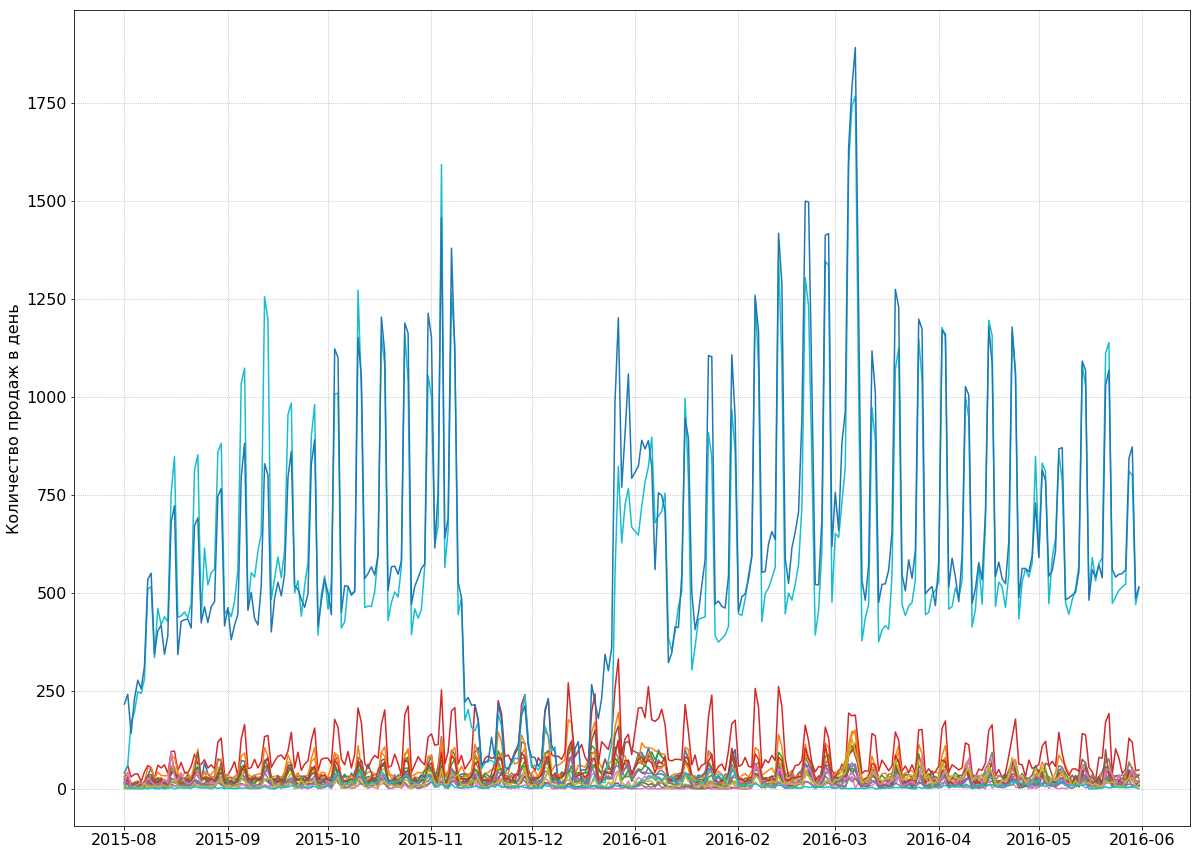

In [8]:
plt.figure(figsize=(20, 15))
plt.plot(timeseries)
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

Изобразим все временные ряды на графике еще раз, убрав два самых популярных товара.

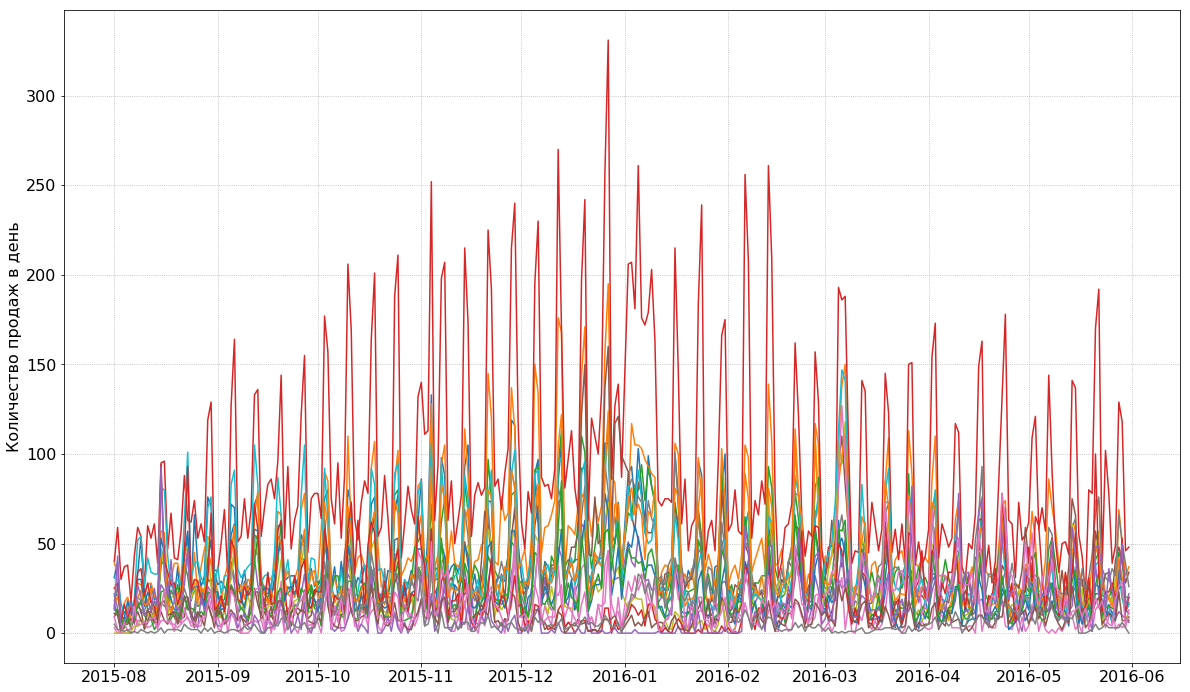

In [9]:
plt.figure(figsize=(20, 12))
plt.plot(timeseries.iloc[:, (np.arange(20) > 10) | (np.arange(20) < 9)])
plt.grid(ls=':')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.ylabel('Количество продаж в день', fontsize=16)
plt.show()

In [10]:
# Эта функция вам уже встречалась в одном задании.
# Позволяем получать argmin в виде мультииндекса.
def cool_argmin(array):
    return np.unravel_index(np.argmin(array), array.shape)

Для каждого ряда переберем вручную кучу вариантов модели и выберем лучшую модель по AIC.

In [ ]:
ps, ds, qs, Ps, Qs = 4, 2, 4, 4, 3  # количество параметров каждого типа для перебора
optim_params = np.zeros((20, 5), dtype=int)  # тут будут оптимальные параметры для каждого ряда

for i in tqdm_notebook(range(20)):  # цикл по товарам
    
    # временной ряд
    y = np.array(timeseries.iloc[:, i], dtype=float)
    
    # Тут будут значения AIC для всех моделей. Некоторые модели могут по разным причинам не рассчитатья,
    # поэтому значением по умолчанию будет 10^10 (значения нужно минимизировать).
    aic = np.zeros((ps,ds, qs, Ps, Qs)) + 10**10
    
    # Перебор параметров
    for p in tqdm_notebook(range(ps), leave=False):
        for d in tqdm_notebook(range(ds), leave=False):
            for q in tqdm_notebook(range(qs), leave=False):
                for P in tqdm_notebook(range(Ps), leave=False):
                    for Q in tqdm_notebook(range(Qs), leave=False):
                        
                        try:
                            
                            # Задаем модель (период сезонности = 7, т.е. неделя)
                            model = sm.tsa.statespace.SARIMAX(y, order=(p, d, q), 
                                                              seasonal_order=(P+1, 1, Q+1, 7), 
                                                              enforce_stationarity=False, 
                                                              enforce_invertibility=False)
                            # Обучаем модель
                            model = model.fit()
                            # Запоминаем AIC
                            aic[p, d, q, P, Q] = model.aic
                            
                        # Если модель не рассчиталась, то пропускаем ее
                        except Exception:
                            pass
                        
    # Запоминаем параметры (индексы) у лучшей модели по AIC
    optim_params[i] = cool_argmin(aic)

Значения AIC на последней итерации

In [19]:
aic

array([[[[[ 2034.5778081 ,  1993.23477292,  1918.575688  ],
          [ 1999.96029958,  1991.82580292,  1904.81465209],
          [ 1958.22545237,  1951.58349933,  1906.95231987],
          [ 1864.01603954,  1866.01307703,  1861.57579097]],

         [[ 1928.70989131,  1890.46654522,  1818.0265606 ],
          [ 1902.08078288,  1867.60463285,  1812.81015443],
          [ 1862.59461505,  1839.39872749,  1823.69403943],
          [ 1781.82437118,  1783.7347055 ,  1783.62579586]],

         [[ 1886.67343768,  1849.40887118,  1782.00651908],
          [ 1845.83944715,  1827.30289491,  1781.28250114],
          [ 1804.70139948,  1805.4211237 ,  1786.78534097],
          [ 1758.89431377,  1760.89320413,  1760.72728049]],

         [[ 1855.0648237 ,  1835.3383969 ,  1769.07467119],
          [ 1838.90285309,  1813.80858342,  1769.25234922],
          [ 1797.66383521,  1798.02250561,  1774.11782678],
          [ 1753.77757093,  1755.67618436,  1757.16235738]]],


        [[[ 1878.66512444,  18

Оптимальные параметры для каждого ряда

In [20]:
optim_params

array([[3, 1, 2, 3, 0],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 0, 0, 3, 2],
       [3, 0, 0, 3, 0],
       [3, 0, 1, 3, 2],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 1, 3, 3, 1],
       [3, 0, 2, 3, 0],
       [3, 1, 2, 3, 0],
       [3, 1, 1, 3, 0],
       [3, 0, 3, 3, 2],
       [3, 1, 1, 3, 2],
       [2, 1, 3, 3, 0]])

Для каждого ряда снова обучаем оптимальную модель и строим прогнозы.

In [12]:
forecast_len = 30  # горизонт прогнозирования
predicted = np.zeros((20, forecast_len))  # тут будут прогнозы

# цикл по товарам
for i in tqdm_notebook(range(20)):
    # временной ряд
    y = np.array(timeseries.iloc[:, i], dtype=float)
    # подобранные оптимальные параметры
    p, d, q, P, Q = optim_params[i]
    
    # Задаем модель.
    # Нужно ручное преобразование из numpy.in32 в int, иначе будет ошибка.
    model = sm.tsa.statespace.SARIMAX(y, 
                                      order=(int(p), int(d), int(q)), 
                                      seasonal_order=(int(P), 1, int(Q), 7), 
                                      enforce_stationarity=False, enforce_invertibility=False)
    # Обучаем модель
    model = model.fit()
    # Считаем прогнозы
    predicted[i] = model.get_forecast(steps=forecast_len).predicted_mean

Результат записываем в файл

In [13]:
t = pd.DataFrame(predicted.ravel())
t.columns = ['Count']
t.index.name = 'Id'
t.to_csv('baseline.csv')

Дополнительно нужно заменить отрицательные числа на нули --- нельзя продать отрицательное число товара.